# INTRODUCTION

By Aroso Emmanuel A.

The following project explores how we make a Convolution-based Neural Network (ConvNet) to perform road anomaly classification on inertial sensor signals captured from the dashboard of vehicles. We train a model from scratch since such signal-classification models that meet our requirements are scarce in pre-trained format. The data we use is sourced from the [Passive Vehicular Sensor](https://www.kaggle.com/datasets/jefmenegazzo/pvs-passive-vehicular-sensors-datasets) dataset where the data was collected while driving on three different road contexts, using three different drivers and three different vehicles.

# SETUP

## Install and Import the Dependencies.

In [ ]:
!pip install livelossplot --quiet
!pip install -q -U keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import gc
import json
import shutil
import time
import random
import IPython
import librosa as lr
import librosa.display
from IPython.display import display
import scipy.signal as signal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping, Callback
from tensorflow.keras.layers import GlobalMaxPooling1D, AveragePooling1D , Input, Activation, Dense, Dropout, SpatialDropout1D, Conv1D, TimeDistributed, MaxPooling1D, Flatten, ConvLSTM2D, Bidirectional, BatchNormalization, GlobalAvgPool1D, GlobalAveragePooling1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF
import keras_tuner as kt
print("Using Tensorflow", tf.__version__)

Using Tensorflow 2.12.0


## Data Parameters

In [ ]:
try:
    import google.colab
    from google.colab import output, drive
    drive.mount('/content/drive', force_remount=False)
    IN_COLAB = True
    datasets_folder = '/content/drive/My Drive/Colab Notebooks/DataSets/'
    experiments_folder = '/content/drive/My Drive/Colab Notebooks/Experiments/'
except:
    IN_COLAB = False
    output = None
    datasets_folder = '/Google Drive/Colab Notebooks/DataSets/'
    experiments_folder = '/Google Drive/Colab Notebooks/Experiments/'

print("In Colab:", IN_COLAB)
print("Dataset Folder:", datasets_folder)
print("Experiments Folder:", experiments_folder)

Mounted at /content/drive
In Colab: True
Dataset Folder: /content/drive/My Drive/Colab Notebooks/DataSets/
Experiments Folder: /content/drive/My Drive/Colab Notebooks/Experiments/


## Packages Parameters

In [ ]:
plt.rcParams["figure.figsize"] = (16,6)
pd.options.display.float_format = '{:.5f}'.format

# LOAD THE DATA: PVS

In [ ]:
# Load raw datasets (PVS 1 - 8) from disk, leaving out PVS 9 for testing
# Input: folder where is the datasets folder and files
# Output: dict -> { "pvs_x": { "left": df, "right": df, "labels": df } }
def getDataSets(folder=datasets_folder):

    datasets = {}
    # Load the first 8 datasets
    for i in range(1, 9):

        dataset_folder = os.path.join(folder, "PVS " + str(i))

        left =   pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_left.csv'), dtype=np.float32) # ,  float_precision="high"
        right =  pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_right.csv'), dtype=np.float32) # ,  float_precision="high"
        labels = pd.read_csv(os.path.join(dataset_folder, 'dataset_labels.csv'), dtype=np.uint8)

        datasets["pvs_" + str(i)] = {
            "left": left,
            "right": right,
            "labels": labels
        }

    return datasets

In [ ]:
datasets = getDataSets()

In [ ]:
datasetsdatasets

# VISUALIZATION AND EXPLORATORY ANALYSIS

## Quick Look

## Persistent Anomalies Visualization

## Transient Anomalies Visualiztion

In [ ]:
def plotSpeedBump(start, end):
    dataset = "pvs_2"
    side = "left"
    data = datasets[dataset][side][start:end]
    labels = datasets[dataset]["labels"][["speed_bump_asphalt", "speed_bump_cobblestone"]][start:end]

    acc_below_suspension = getFields(acc=True, below_suspension=True)
    acc_above_suspension = getFields(acc=True, above_suspension=True)
    acc_dashboard = getFields(acc=True, dashboard=True)

    gyro_below_suspension = getFields(gyro=True, below_suspension=True)
    gyro_above_suspension = getFields(gyro=True, above_suspension=True)
    gyro_dashboard = getFields(gyro=True, dashboard=True)

    x = np.arange(end - start)

    fig = plt.figure(figsize=(14,4))
    ((ax1, ax2, ax3), (ax4, ax5, ax6)) = fig.subplots(2, 3)

    ax1.set_ylabel("Acceleration (m/s²)")
    ax1.plot(x, data[acc_below_suspension])
    ax1.set_title("Near/Below Suspension")
    ax2.plot(x, data[acc_above_suspension])
    ax2.set_title("Near/Above Suspension")
    # ax3.plot(x, data[])
    line = ax3.plot(x, data[acc_dashboard])
    ax3.set_title("Speed Bump Asphalt")
    ax3.legend(line, ("X", "Y", "Z"), loc="center right")

    ax4.set_ylabel("Rotarion Rate (deg/s)")
    ax4.plot(x, data[gyro_below_suspension])
    ax4.set_xlabel("Number of samples")
    ax5.plot(x, data[gyro_above_suspension])
    ax5.set_xlabel("Number of samples")
    line = ax6.plot(x, data[gyro_dashboard])
    ax6.set_xlabel("Number of samples")


    # fig.legend(line, ("X", "Y", "Z"), loc="lower center", mode = "expand", ncol = 3, bbox_to_anchor=(0.45,0))
    # fig.legend(line, ("X", "Y", "Z"), loc="upper left", ncol = 1, bbox_to_anchor=(1.005,1.15))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

In [ ]:
def plotSpeedBumpAsphalt():
    plotSpeedBump(29600, 30300) # (119400, 120150)
    plt.savefig("speed_bump_asphalt", bbox_inches = "tight")

In [ ]:
def plotSpeedBumpCobblestone():
    plotSpeedBump(53800, 54500) # (45500, 46200) (51000, 51700)
    plt.savefig("speed_bump_cobblestone", bbox_inches = "tight")

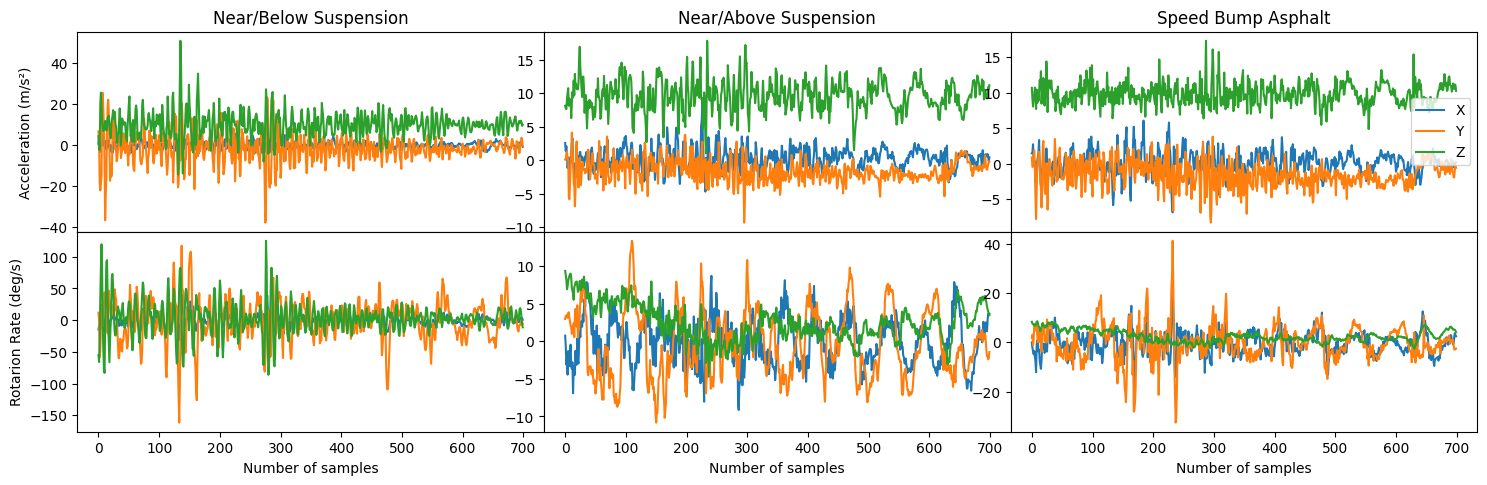

In [ ]:
plotSpeedBumpAsphalt()

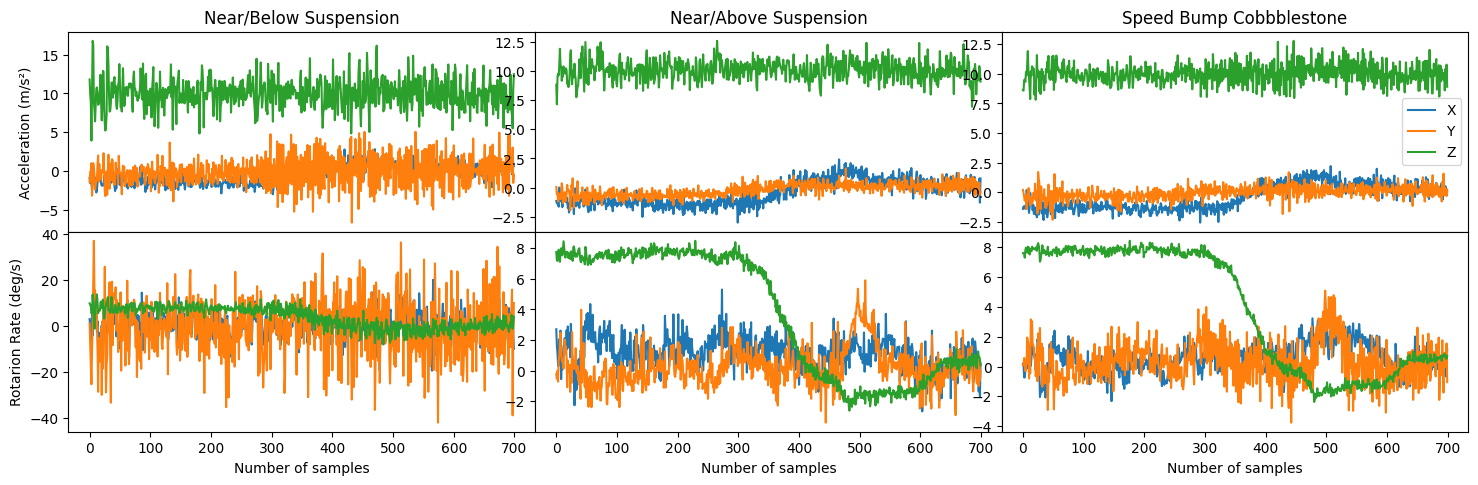

In [ ]:
plotSpeedBumpCobblestone()

# PREPROCESSING

## Dataset Functions

In [ ]:
def getFields(acc=False, gyro=False, mag=False, temp=False, speed=False, location=False, below_suspension=False, above_suspension=False, dashboard=False):

    """Get fields names filtering by data type and placement.

    Args:
        acc (bool): to return accelerometer fields.
            (default is False)
        gyro (bool): to return gyroscope fields.
            (default is False)
        mag (bool): to return magnetometer fields.
            (default is False)
        temp (bool): to return temperature field.
            (default is False)
        speed (bool): to return speed field.
            (default is False)
        location (bool): to return GPS location fields.
            (default is False)
        below_suspension (bool): to return fields of data sampled next and below suspension.
            (default is False)
        above_suspension (bool): to return fields of data sampled next and above suspension.
            (default is False)
        dashboard (bool): to return fields of data sampled in the dashboard.
            (default is False)

    Returns:
        list: list of fields.
    """

    all_fields = [
        'timestamp',
        'acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard',
        'acc_x_above_suspension', 'acc_y_above_suspension', 'acc_z_above_suspension',
        'acc_x_below_suspension', 'acc_y_below_suspension', 'acc_z_below_suspension',
        'gyro_x_dashboard', 'gyro_y_dashboard', 'gyro_z_dashboard',
        'gyro_x_above_suspension', 'gyro_y_above_suspension', 'gyro_z_above_suspension',
        'gyro_x_below_suspension', 'gyro_y_below_suspension', 'gyro_z_below_suspension',
        'mag_x_dashboard', 'mag_y_dashboard', 'mag_z_dashboard',
        'mag_x_above_suspension', 'mag_y_above_suspension', 'mag_z_above_suspension',
        'temp_dashboard', 'temp_above_suspension', 'temp_below_suspension',
        'timestamp_gps', 'latitude', 'longitude', 'speed'
    ]

    return_fields = []

    for field in all_fields:

        data_type = False
        placement = False

        if(speed and field == "speed"):
            placement = data_type = True

        if(location and (field == "latitude" or field == "longitude")):
            placement = data_type = True

        if(acc):
            data_type = data_type or field.startswith("acc_")

        if(gyro):
            data_type = data_type or field.startswith("gyro_")

        if(mag):
            data_type = data_type or field.startswith("mag_")

        if(temp):
            data_type = data_type or field.startswith("temp_")

        if(below_suspension):
            placement = placement or field.endswith("_below_suspension")

        if(above_suspension):
            placement = placement or field.endswith("_above_suspension")

        if(dashboard):
            placement = placement or field.endswith("_dashboard")

        if(data_type and placement):
            return_fields.append(field)

    return return_fields

def getSubSets(datasets, fields, labels):

    """Get subsets from raw datasets. For each PVS dataset, extract a subset with only fields/labels passed.

    Args:
        datasets (dict): raw PVS datasets.
        fields (string[]): fields to extract.
        labels (string[]): labels to extract.

    Returns:
        dict: subsets in dict form:
        {
            "pvs_x": {
                "left": DataFrame,
                "right": DataFrame,
                "labels": DataFrame
            }
        }
    """

    subsets = {}

    for key in datasets.keys():

        subsets[key] = {
            "left": datasets[key]["left"][fields],
            "right": datasets[key]["right"][fields],
            "labels": datasets[key]["labels"][labels]
        }

    return subsets


In [ ]:
# fields = ['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard']
# labels = ["asphalt_road", "dirt_road"]

# subsets = getSubSets(datasets, fields, labels)


In [ ]:
# subsets

## Nomalize the Data

In [ ]:
# Get normalized data using MinMaxScaler.
# Input: subsets (dict).
# Output: dict -> { "pvs_x": { "left": df, "right": df, "labels": df } }
def getNormalizedDataMinMax(subsets, scaler_range=(-1,1)):

    scaler = MinMaxScaler(feature_range=scaler_range)
    return getNormalizedData(subsets, scaler)

def getNormalizedData(subsets, scaler):

    normalized_sets = {}
    learn_data = pd.DataFrame()

    for pvs in subsets.keys():
        for side in ["left", "right"]:
            learn_data = learn_data.append(subsets[pvs][side], ignore_index=True)

    scaler = scaler.fit(learn_data)
    del learn_data

    for pvs in subsets.keys():

        normalized_sets[pvs] = {
            'left':  pd.DataFrame(data=scaler.transform(subsets[pvs]['left']),  columns=subsets[pvs]['left'].columns),
            'right': pd.DataFrame(data=scaler.transform(subsets[pvs]['right']), columns=subsets[pvs]['right'].columns),
            'labels': subsets[pvs]['labels']
        }

    return normalized_sets

# Reshape and Flatten data
# Inputs: subsets to be reshaped
# outputs: reshaped dict ->  {  "pvs_x": { "left": np.array, "right": np.array, "labels": np.array }  }
# shape: shape to reshape data to. Must have the form (..., ..., ..., features)
def getReshapedData(subsets, shape, moving_window, mode_label):

    reshaped_sets = {}

    shape = tuple([x for x in shape if x is not None])

    for key in subsets.keys():

        reshaped_sets[key] = {};

        for side in ['left', 'right']:

            inputs = subsets[key][side].values
            outputs = subsets[key]["labels"].values

            window = 1

            for dim in shape:
                window = window * dim

            window = int(window / len(inputs[0]))

            if moving_window:

                inputs_reshaped = []

                if mode_label:
                    outputs_reshaped = []
                else:
                    outputs_reshaped = outputs[window-1:]

                for i in range(window, len(inputs)+1):
                    value = inputs[i-window:i, :]
                    value = value.reshape(shape)
                    inputs_reshaped.append(value)

                    if mode_label:
                        outputs_reshaped.append(outputs[i-window:i, :].mean(axis=0).round(0))

            else:

                inputs_reshaped = []
                outputs_reshaped = []

                chuncks = int(len(inputs)/window)

                for i in range(0, chuncks):
                    value = inputs[i*window : (i+1)*window, :]
                    value = value.reshape(shape)
                    inputs_reshaped.append(value)

                    if mode_label:
                        outputs_reshaped.append(outputs[i*window : (i+1)*window, :].mean(axis=0).round(0))
                    else:
                        outputs_reshaped.append(outputs[((i+1)*window)-1])

            reshaped_sets[key][side] = np.array(inputs_reshaped) # inputs_reshaped
            reshaped_sets[key]['labels'] = np.array(outputs_reshaped) # outputs_reshaped
            del inputs_reshaped, outputs_reshaped

    return reshaped_sets

## Splitting the Data

In [ ]:
# Get train and test sets from normalized sets.
# Inputs: normalized sets (dict), sets_train (string[]) and sets_test (string[]), sides to be used in train and validation.
# Outputs: df -> input train (list|np.array), input validation (list|np.array), output train (list|np.array), output validation (list|np.array)
def getTrainValidationSets(reshaped_sets, sets_train, sets_test, sides=['left', 'right']):

    input_train = []
    input_validation = []
    output_train = []
    output_validation = []

    for key in reshaped_sets.keys():

        for side in sides:

            inputs = reshaped_sets[key][side]
            outputs = reshaped_sets[key]["labels"]

            if (key in sets_train):

                for inp in inputs:
                    input_train.append(inp)

                for out in outputs:
                    output_train.append(out)

            elif (key in sets_test):

                for inp in inputs:
                    input_validation.append(inp)

                for out in outputs:
                    output_validation.append(out)

    return np.array(input_train), np.array(input_validation), np.array(output_train), np.array(output_validation) # input_train, input_test, output_train, output_test

## Experiment Parameters

In [ ]:
experiment_by_dataset = [
    {   # This dataset division employed for training the convnet model
        # The model learns data from all vehicles and drivers for some scenarios,
        # but not all vehicles with all drivers for all scenarios.
        "train": ["pvs_1", "pvs_3", "pvs_4", "pvs_6", "pvs_7"],
        "test":  ["pvs_2", "pvs_5", "pvs_8"]
     },
    {   # This dataset division was not employed for training any model
        "train": ["pvs_1", "pvs_2", "pvs_3", "pvs_7", "pvs_8"],
        "test":  ["pvs_4", "pvs_5", "pvs_6"]
     },
    {   # This dataset division employed for training the RNN model
        # The model learns data from some vehicles with some drivers for some scenarios,
        # but not all vehicles with all drivers for all scenarios.
        "train": ["pvs_1", "pvs_2", "pvs_4", "pvs_6", "pvs_8"],
        "test":  ["pvs_3", "pvs_5", "pvs_7"]
     }
]

experiment_by_fields = [
    ("Below Suspension", getFields(acc=False, gyro=False, speed=False, below_suspension=False)),
    ("Above Suspension", getFields(acc=False, gyro=False, speed=False, above_suspension=False)),
    # The dashnoard is the only placement used was for training our models
    ("Dashboard",        getFields(acc=True, gyro=False, speed=False, dashboard=True))
]

In [ ]:
# experiment_by_fields

[('Below Suspension', []),
 ('Above Suspension', []),
 ('Dashboard', ['acc_x_dashboard', 'acc_y_dashboard', 'acc_z_dashboard'])]

## Label Fields

In [ ]:
moving_window=False
last_label=False
surface_type_labels = ["dirt_road", "cobblestone_road", "asphalt_road"]

In [ ]:
surface_type_labels_plot = ["Dirt \n Road", "Cobblestone \n Road", "Asphalt \n Road"]

# PROCESSING

## Functions to generate the CNN Model

In [ ]:
# Accelerate training computation speed with use of TPU
tpu_initialized = False  # Flag to track TPU initialization

if not tpu_initialized:
    try:
        # Initialize TPU
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        tpu_strategy = tf.distribute.TPUStrategy(resolver)
        tpu_initialized = True  # Update the flag
        print("TPU initialized successfully!")
    except Exception as e:
        print("Failed to initialize TPU:", str(e))

TPU initialized successfully!


In [ ]:
# Model architecture for our ConvNet
# Modified version of https://ieeexplore.ieee.org/document/9277846/
def model(name):

    def modelBuilder(n_convolutional, n_features, n_outputs):

        # Create and compile the model within the tpu_strategy.scope()
        with tpu_strategy.scope():

            model = Sequential()

            model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_convolutional, n_features)))
            model.add(BatchNormalization())
            model.add(SpatialDropout1D(0.15))

            model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
            model.add(BatchNormalization())
            model.add(SpatialDropout1D(0.15))

            model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
            model.add(GlobalAvgPool1D())
            model.add(BatchNormalization())
            model.add(Dropout(0.15))

            model.add(Dense(32, activation='relu'))
            model.add(Dense(n_outputs, activation='softmax'))
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        return model, name

    return modelBuilder

In [ ]:
def parameters(input_shape, output_shape):

    return {
        "n_convolutional": input_shape[1],
        "n_features": input_shape[2],
        "n_outputs": output_shape[1]
    }

In [ ]:
sides = ['left', 'right']
mode_label = True
moving_window = False
input_features = 3

In [ ]:
# (batches, window size, features)
input_shapes = [
    ((None, 300, input_features), 300)
]

output_shape = (None, 3)

## Model Management

In [ ]:
def createPathIfNotExists(path):

    if not os.path.exists(path):
        os.makedirs(path)

def modelFileSavedFormat(file):
    return file + '-train-acc-{acc:.5f}-val-acc-{val_acc:.5f}.hdf5'

def saveModelDiagram(model, path, file, show=True):
    createPathIfNotExists(path)
    plot_model(model, to_file=os.path.join(path, file + '.png'), show_shapes=True, show_layer_names=True)

    if show:
        display(plot_model(model, show_shapes=True, show_layer_names=True))
        display(model.summary())

def showHistory(history):

    for key in history.history.keys():
        plt.plot(history.history[key], label=key)

    plt.legend()

def fitModel(model, input_train, output_train, inputs_validation, outputs_validation, path, file, batch_size=64, epochs=10000, patience=50):

    createPathIfNotExists(path)

    plotlosses = PlotLossesKerasTF()

    checkpoint_file_validation = os.path.join(path, modelFileSavedFormat(file))
    checkpoint_validation = ModelCheckpoint(filepath=checkpoint_file_validation, save_best_only=True, monitor='val_acc', mode='max') # verbose=1

    early_stopping = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=patience, min_delta=0.0001, restore_best_weights=True)

    callbacks=[plotlosses, checkpoint_validation, early_stopping]

    with tpu_strategy.scope():

        return model.fit(input_train, output_train, validation_data=(inputs_validation, outputs_validation), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0) # verbose=1

def predictModel(model, inputs):
    return model.predict(inputs)

def evaluateModel(model, inputs, outputs, batch_size=64):
    return model.evaluate(inputs, outputs, batch_size=batch_size, verbose=0)

def loadWeights(model, pathFile):
    model.load_weights(pathFile)

## Training Functions

In [ ]:
# Save a log for each experiment execution (params for each execution)
def saveExecutionLog(path, data, columns=['placement', 'experiment', "window", "scaler", "input_shape", "output_shape", "train_loss", "val_loss", "train_acc", "val_acc"]):
    save = pd.DataFrame(data=data, columns=columns)
    save.to_csv(os.path.join(path, "experiment-execution-log.csv"), index=False)

In [ ]:
# Retrieve best model from num_tests executions
def manageFiles(history, experiment_folder, experiment_file):

    test = -1
    index = -1
    val_acc = -1

    for i in range(0,2):

        max_value = max(history[i]['val_acc'])

        if max_value > val_acc:
            val_acc = max_value
            test = i
            index = history[i]['val_acc'].index(max_value)

    train_acc = history[test]['acc'][index]
    train_loss = history[test]['loss'][index]
    val_acc = history[test]['val_acc'][index]
    val_loss = history[test]['val_loss'][index]

    test_folder = os.path.join(experiment_folder, "Test " + str(test + 1))
    file = modelFileSavedFormat(experiment_file).format(**{'acc': train_acc, 'val_acc': val_acc})

    move_from = os.path.join(test_folder, file)
    move_to = os.path.join(experiment_folder, file)

    shutil.move(move_from, move_to)

    for i in range(0,2):
        shutil.rmtree(os.path.join(experiment_folder, "Test " + str(i + 1)))

    return [train_loss, val_loss, train_acc, val_acc]

In [ ]:
# Load bar for experiments progress
def getLoadBar():

    global load_bar_placement, load_bar_dataset, load_bar_experiment, load_bar_retries

    experiment_total_placement = len(experiment_by_fields)
    experiment_total_dataset = len(experiment_by_dataset)
    experiment_total_iteration = len(input_shapes)

    load_bar_placement = tqdm(total=experiment_total_placement, desc='Placement Progress')
    load_bar_dataset = tqdm(total=experiment_total_dataset, desc='Dataset Progress')
    load_bar_experiment = tqdm(total=experiment_total_iteration, desc='Input Shapes Progress')
    load_bar_retries = tqdm(total=2, desc='Retries')

In [ ]:
def run(model_fn, batch_size=64, patience=50, epochs=10000, retries=2):

    load_bar_placement.reset()

    placement, fields = experiment_by_fields[2]

    load_bar_placement.set_description(placement)
    load_bar_dataset.reset()

    subsets = getSubSets(datasets.copy(), fields, surface_type_labels)
    # print(subsets)
    normalized_sets = getNormalizedDataMinMax(subsets, (-1,1))
    # print(normalized_sets)

    # Clean Memory
    del subsets
    gc.collect()

    for experiment_number in range(0, 1):

        load_bar_experiment.reset()
        load_bar_experiment.set_description("Experiment " + str(experiment_number + 1))

        sets_train = experiment_by_dataset[experiment_number]['train']
        sets_test = experiment_by_dataset[experiment_number]['test']

        execution_log = []

        for input_shape, window_size in input_shapes:

            model_args = parameters(input_shape, output_shape)

            history = []

            reshaped_sets = getReshapedData(normalized_sets.copy(), input_shape, moving_window, mode_label)
            input_train, input_test, output_train, output_test = getTrainValidationSets(reshaped_sets, sets_train, sets_test, sides)
            del reshaped_sets
            gc.collect()

            print("Input Train Shape:", input_train.shape, "Output Train Shape:", output_train.shape)
            print("Input Validation Shape:", input_test.shape, "Output Validation Shape:", output_test.shape)

            for test in range(0, retries):

                model, model_name = model_fn(**model_args)

                experiment_folder = os.path.join(experiments_folder, model_name, placement, "Experiment " + str(experiment_number + 1))
                test_folder = os.path.join(experiment_folder, "Test " + str(test + 1))
                diagram_file = "experiment-" + str(experiment_number + 1) + "-window-" + str(window_size)
                experiment_file = diagram_file + "-min-max-scaler-" + "(-1,1)"

                saveModelDiagram(model, experiment_folder, diagram_file)
                hist = fitModel(model, input_train, output_train, input_test, output_test, test_folder, experiment_file, patience=patience, batch_size=batch_size, epochs=epochs)

                history.append(hist.history)
                load_bar_retries.update(1)

                # Clean Memory
                del model, hist
                # model, hist = [None, None]

                if not(output is None):
                    output.clear()

                gc.collect()

            metrics = manageFiles(history, experiment_folder, experiment_file)

            execution_log.append([
                placement,
                experiment_number + 1,
                window_size,
                "Min Max Scaler" + "(-1,1)",
                str(input_shape),
                str(output_shape)
            ] + metrics)

            saveExecutionLog(experiment_folder, execution_log)
            load_bar_experiment.update(1)

            # Clean
            del history, input_train, input_test, output_train, output_test, metrics
            load_bar_retries.reset()
            gc.collect()
            time.sleep(5)

        load_bar_dataset.update(1)

    del normalized_sets
    load_bar_placement.update(1)

## Training the Model

In [ ]:
getLoadBar()

Placement Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Input Shapes Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Retries:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
run(
    model("CNN " + "Time" + " Domain " + str(input_features) + " Features")
)

# RESULTS ANALYSIS

## Plot Functions

In [ ]:
# Plot best model CNN 3 features window 300 time domain
def confusionMatrix(files, title, model_fn, input_shape, output_shape, experiment_by_fields):

    placement = experiment_by_fields[0]
    fields = experiment_by_fields[1]
    # placement, fields = experiment_by_fields[2]

    matrix = []
    subsets = getSubSets(datasets.copy(), fields, surface_type_labels)
    normalized_sets = getNormalizedDataMinMax(subsets, (-1,1))
    reshaped_sets = getReshapedData(normalized_sets, input_shape, moving_window, mode_label)

    for experiment_number in range(0,1):

        sets_train = experiment_by_dataset[experiment_number]['train']
        sets_test = experiment_by_dataset[experiment_number]['test']

        input_train, input_test, output_train, output_test = getTrainValidationSets(reshaped_sets.copy(), sets_train, sets_test, sides)

        model_args = parameters(input_shape, output_shape)
        model, model_name = model_fn(**model_args)
        loadWeights(model, os.path.join(experiments_folder, model_name, placement, "Experiment " + str(experiment_number + 1), files[experiment_number]))
        predictions = predictModel(model, input_test)
        matrix.append(confusion_matrix(output_test.argmax(axis=1), predictions.argmax(axis=1))) # , normalize="all"

    # values = ((matrix[0] + matrix[1] + matrix[2])/3)*100
    values = matrix[0]
    con_mat_df = pd.DataFrame(values, index=surface_type_labels_plot, columns=surface_type_labels_plot)
    figure = plt.figure(figsize=(10,4))
    sns.set(font_scale=1.2)
    sns.heatmap(con_mat_df, annot=True, cmap='binary', fmt='g', annot_kws={"size": 14})
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    figure.savefig('confusion_matrix.png', bbox_inches="tight")

In [ ]:
files = [
    'experiment-1-window-300-min-max-scaler-(-1,1)-train-acc-0.89411-val-acc-0.94423.hdf5',
    'experiment-1-window-300-min-max-scaler-(-1,1)-train-acc-0.88991-val-acc-0.94030.hdf5',
    'experiment-1-window-300-min-max-scaler-(-1,1)-train-acc-0.87754-val-acc-0.93559.hdf5'
]

<ipython-input-152-f291fe227e17>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learn_data = learn_data.append(subsets[pvs][side], ignore_index=True)


80/80 [==============================] - 3s 19ms/step


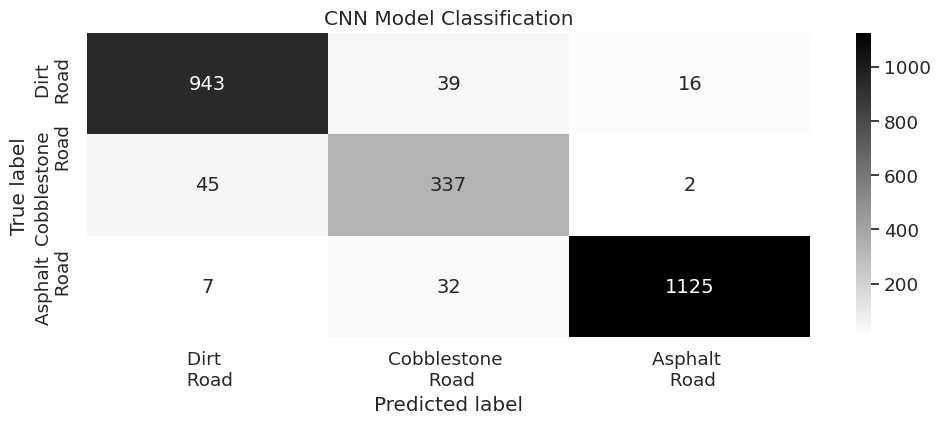

In [ ]:
confusionMatrixconfusionMatrixconfusionMatrixconfusionMatrix(files, "CNN Model Classification", model("CNN Time Domain 3 Features"), (None, 300, 3), (None, 3), experiment_by_fields[2])

## Classification Metrics Report

In [ ]:
def showClassificationReport(files, model_fn, input_shape, output_shape, experiment_by_fields):

    placement = experiment_by_fields[0]
    fields = experiment_by_fields[1]

    # placement, fields = experiment_by_fields[2]

    subsets = getSubSets(datasets.copy(), fields, surface_type_labels)
    normalized_sets = getNormalizedDataMinMax(subsets, (-1,1))
    reshaped_sets = getReshapedData(normalized_sets, input_shape, moving_window, mode_label)

    output_values = []
    predicted_values = []

    for experiment_number in range(0,1):

        sets_train = experiment_by_dataset[experiment_number]['train']
        sets_test = experiment_by_dataset[experiment_number]['test']

        input_train, input_test, output_train, output_test = getTrainValidationSets(reshaped_sets.copy(), sets_train, sets_test, sides)

        model_args = parameters(input_shape, output_shape)
        model, model_name = model_fn(**model_args)
        loadWeights(model, os.path.join(experiments_folder, model_name, placement, "Experiment " + str(experiment_number + 1), files[experiment_number]))
        predictions = predictModel(model, input_test)

        for line in output_test:
            output_values.append(line)

        for line in predictions:
            predicted_values.append(line)

        del input_train, input_test, output_train, output_test

    return classification_report(y_true = np.array(output_values).argmax(axis=1), y_pred = np.array(predicted_values).argmax(axis=1), output_dict=True, target_names=surface_type_labels)

In [ ]:
showClassificationReport(files, model("CNN Time Domain 3 Features"), (None, 300, 3), (None, 3), experiment_by_fields[2])

<ipython-input-152-f291fe227e17>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learn_data = learn_data.append(subsets[pvs][side], ignore_index=True)


80/80 [==============================] - 3s 19ms/step


{'dirt_road': {'precision': 0.9477386934673366,
  'recall': 0.9448897795591182,
  'f1-score': 0.9463120923231308,
  'support': 998},
 'cobblestone_road': {'precision': 0.8259803921568627,
  'recall': 0.8776041666666666,
  'f1-score': 0.8510101010101009,
  'support': 384},
 'asphalt_road': {'precision': 0.984251968503937,
  'recall': 0.9664948453608248,
  'f1-score': 0.9752925877763329,
  'support': 1164},
 'accuracy': 0.9446190102120974,
 'macro avg': {'precision': 0.9193236847093788,
  'recall': 0.92966293052887,
  'f1-score': 0.9242049270365215,
  'support': 2546},
 'weighted avg': {'precision': 0.9460679410868891,
  'recall': 0.9446190102120974,
  'f1-score': 0.9451877137069971,
  'support': 2546}}

## Execution logs

In [ ]:
def getExecutionLogs():

    execution_logs = {}
    columns = ['window', 'train_loss',	'val_loss',	'train_acc', 'val_acc']
    models = os.listdir(os.path.join(experiments_folder))
    models.sort(reverse=True)

    for model in models:

        for placement in ["Dashboard"]:

            placement_logs = []

            for experiment in range(1, 2):

                file = os.path.join(experiments_folder, model, placement, "Experiment " + str(experiment), "experiment-execution-log.csv")

                if os.path.isfile(file):
                    content = pd.read_csv(file)
                    placement_logs.append(content[columns])

            execution_logs[model + " " + placement] = placement_logs

    return execution_logs